# Migrating from Toronto to New York (Capstone Project)

# Table of contents
1. [Introduction](#introduction)
2. [Working with Toronto data](#toronto_data)
3. [Toronto Neighborhoods](#toronto_neighborhoods)
4. [Toronto Venues](#toronto_venues)
5. [Toronto top 10 venues for all neighborhoods](#toronto_top10)
6. [Toronto Neighborhood Clusters](#toronto_clusters)
7. [Working with New York data](#newyork_data)
8. [New York Neighborhoods](#newyork_neighborhoods)
9. [New York Venues](#newyork_venues)
10. [New York top 10 venues for all neighborhoods](#newyork_top10)
11. [New York Neighborhood Clusters](#newyork_clusters)
12. [Explore Recommended Cluster](#recommended_cluster)
13. [Compare top 10 venues of recommended neighborhood with that  of originating neighborhood](#compare)

## Introduction <a name="introduction"></a>

In this project we will analyze neighborhoods in Toronto and New York. We will draw parallel between the  types of neighborhoods in these two cities. We will recommend neighborhoods in New York for someone moving from Toronto.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1

## Working with Toronto data <a name='toronto_data'></a>

### Scrape data frrm wikipedia page¶

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

### Filter out rows with 'Not assigned' Boroughs¶

<a id='item1'></a>

In [3]:
df = df[df['Borough'] != 'Not assigned']

In [4]:
g = df.groupby("Postcode")

In [5]:
#create empty dataframe
new_df = pd.DataFrame(columns=['PostalCode', 'Borough', 'Neighborhood'])

# iterate over group by
for postcode in g.groups:
    l = g.groups[postcode]
    n = ''
    b = ''
    for e in l:
        n +=  (df.loc[e]['Neighbourhood'] + ',')
        b = df.loc[e]['Borough']
    # append to dataframe
    new_df = new_df.append({'PostalCode' : postcode, 'Borough' : b, 'Neighborhood' : n}, ignore_index=True)

In [6]:
new_df.head()

PostalCode      Borough                           Neighborhood
0        M1B  Scarborough                         Rouge,Malvern,
1        M1C  Scarborough  Highland Creek,Rouge Hill,Port Union,
2        M1E  Scarborough       Guildwood,Morningside,West Hill,
3        M1G  Scarborough                                Woburn,
4        M1H  Scarborough                             Cedarbrae,

### get geo coordinates for Toronto neighborhoods

In [7]:
geo_coords = pd.read_csv('https://cocl.us/Geospatial_data')

In [8]:
geo_coords.rename(columns={'Postal Code' : 'PostalCode'}, inplace = True)

### merge above two dataframes

## Toronto Neighborhoods <a name='toronto_neighborhoods'></a>

In [9]:
m = pd.merge(new_df, geo_coords, on='PostalCode')
m.head()

PostalCode      Borough                           Neighborhood   Latitude  \
0        M1B  Scarborough                         Rouge,Malvern,  43.806686   
1        M1C  Scarborough  Highland Creek,Rouge Hill,Port Union,  43.784535   
2        M1E  Scarborough       Guildwood,Morningside,West Hill,  43.763573   
3        M1G  Scarborough                                Woburn,  43.770992   
4        M1H  Scarborough                             Cedarbrae,  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

#### Define Foursquare Credentials and Version

In [115]:
CLIENT_ID = '...' # your Foursquare ID
CLIENT_SECRET = '...' # your Foursquare Secret
VERSION = '20200316' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ...
CLIENT_SECRET:...


In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Function to get nearby venues

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Toronto Venues <a name='toronto_venues'></a>

In [14]:
toronto_venues = getNearbyVenues(names=m['Neighborhood'], latitudes=m['Latitude'], longitudes=m['Longitude'])

Rouge,Malvern,
Highland Creek,Rouge Hill,Port Union,
Guildwood,Morningside,West Hill,
Woburn,
Cedarbrae,
Scarborough Village,
East Birchmount Park,Ionview,Kennedy Park,
Clairlea,Golden Mile,Oakridge,
Cliffcrest,Cliffside,Scarborough Village West,
Birch Cliff,Cliffside West,
Dorset Park,Scarborough Town Centre,Wexford Heights,
Maryvale,Wexford,
Agincourt,
Clarks Corners,Sullivan,Tam O'Shanter,
Agincourt North,L'Amoreaux East,Milliken,Steeles East,
L'Amoreaux West,
Upper Rouge,
Hillcrest Village,
Fairview,Henry Farm,Oriole,
Bayview Village,
Silver Hills,York Mills,
Newtonbrook,Willowdale,
Willowdale South,
York Mills West,
Willowdale West,
Parkwoods,
Don Mills North,
Flemingdon Park,Don Mills South,
Bathurst Manor,Downsview North,Wilson Heights,
Northwood Park,York University,
CFB Toronto,Downsview East,
Downsview West,
Downsview Central,
Downsview Northwest,
Victoria Village,
Woodbine Gardens,Parkview Hill,
Woodbine Heights,
The Beaches,
Leaside,
Thorncliffe Park,
East Toronto,
The Danf

In [15]:
toronto_venues.head()

Neighborhood  Neighborhood Latitude  \
0                         Rouge,Malvern,              43.806686   
1  Highland Creek,Rouge Hill,Port Union,              43.784535   
2       Guildwood,Morningside,West Hill,              43.763573   
3       Guildwood,Morningside,West Hill,              43.763573   
4       Guildwood,Morningside,West Hill,              43.763573   

   Neighborhood Longitude                  Venue  Venue Latitude  \
0              -79.194353                Wendy's       43.807448   
1              -79.160497  Royal Canadian Legion       43.782533   
2              -79.188711      G & G Electronics       43.765309   
3              -79.188711             Marina Spa       43.766000   
4              -79.188711       Big Bite Burrito       43.766299   

   Venue Longitude        Venue Category  
0       -79.199056  Fast Food Restaurant  
1       -79.163085                   Bar  
2       -79.191537     Electronics Store  
3       -79.191000                   Spa  
4       -79.190720    Mexican Restaurant

In [16]:
toronto_venues.shape

(2233, 7)

In [17]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Adelaide,King,Richmond,                                               100   
Agincourt North,L'Amoreaux East,Milliken,Steele...                      2   
Agincourt,                                                              4   
Albion Gardens,Beaumond Heights,Humbergate,Jame...                     10   
Alderwood,Long Branch,                                                  9   
Bathurst Manor,Downsview North,Wilson Heights,                         21   
Bayview Village,                                                        4   
Bedford Park,Lawrence Manor East,                                      24   
Berczy Park,                                                           55   
Birch Cliff,Cliffside West,                                             4   
Bloordale Gardens,Eringate,Markland Wood,Old Bu...                      9   
Brockton,Exhibition Place,Parkdale Village,                            25   
Business Reply Mail Processing Centre 969 Eastern,                     17   
CFB Toronto,Downsview East,                                             3   
CN Tower,Bathurst Quay,Island airport,Harbourfr...                     17   
Cabbagetown,St. James Town,                                            45   
Caledonia-Fairbanks,                                                    4   
Canada Post Gateway Processing Centre,                                 12   
Cedarbrae,                                                              8   
Central Bay Street,                                                    80   
Chinatown,Grange Park,Kensington Market,                               88   
Christie,                                                              18   
Church and Wellesley,                                                  86   
Clairlea,Golden Mile,Oakridge,                                         10   
Clarks Corners,Sullivan,Tam O'Shanter,                                 12   
Cliffcrest,Cliffside,Scarborough Village West,                          3   
Cloverdale,Islington,Martin Grove,Princess Gard...                      1   
Commerce Court,Victoria Hotel,                                        100   
Davisville North,                                                       9   
Davisville,                                                            35   
Deer Park,Forest Hill SE,Rathnelly,South Hill,S...                     14   
Del Ray,Keelesdale,Mount Dennis,Silverthorn,                            3   
Design Exchange,Toronto Dominion Centre,                              100   
Don Mills North,                                                        6   
Dorset Park,Scarborough Town Centre,Wexford Hei...                      5   
Dovercourt Village,Dufferin,                                           18   
Downsview Central,                                                      2   
Downsview Northwest,                                                    5   
Downsview West,                                                         6   
Downsview,North Park,Upwood Park,                                       4   
East Birchmount Park,Ionview,Kennedy Park,                              6   
East Toronto,                                                           4   
Emery,Humberlea,                                                        1   
Fairview,Henry Farm,Oriole,                                            65   
First Canadian Place,Underground city,                                100   
Flemingdon Park,Don Mills South,                                       22   
Forest Hill North,Forest Hill West,                                     4   
Glencairn,                                                              5   
Guildwood,Morningside,West Hill,                                        8   
Harbord,University of Toronto,                                         36   
Harbourfront East,Toronto Islands,Union Station,

In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 265 uniques categories.


In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Yoga Studio  Accessories Store  Afghan Restaurant  Airport  \
0            0                  0                  0        0   
1            0                  0                  0        0   
2            0                  0                  0        0   
3            0                  0                  0        0   
4            0                  0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0                    0                 0                   0              0   
1                    0                 0                   0              0   
2                    0                 0                   0              0   
3                    0                 0                   0              0   
4                    0                 0                   0              0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    1               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
0                 0                 0                   0      0   
1                 0                 0                   0      0   
2                 0                 0                   0      0   
3                 0                 0                   0      0   
4                 0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bike Shop  \
0                0         0           0                   0          0   
1                0         0           0                   0          0   
2                0         0           0                   0          0   
3                0         0           0                   0          0   
4                0         0           0                   0          0   

   Bistro  Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  \
0       0              0          0         0                     0   
1       0              0          0         0                     0   
2       0              0          0         0                     0   
3       0              0          0         0                     0   
4       0              0          0         0                     0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Building  \
0               0        0            0                0         0   
1               0        0            0                0         0   
2               0        0            0                0         0   
3               0        0            0                0         0   
4               0        0            0                0         0   

   Burger Joint  Burrito Place  Bus Line  Bus Station  Bus

In [20]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

Neighborhood  Yoga Studio  \
0                             Adelaide,King,Richmond,     0.000000   
1   Agincourt North,L'Amoreaux East,Milliken,Steel...     0.000000   
2                                          Agincourt,     0.000000   
3   Albion Gardens,Beaumond Heights,Humbergate,Jam...     0.000000   
4                              Alderwood,Long Branch,     0.000000   
5      Bathurst Manor,Downsview North,Wilson Heights,     0.000000   
6                                    Bayview Village,     0.000000   
7                   Bedford Park,Lawrence Manor East,     0.000000   
8                                        Berczy Park,     0.000000   
9                         Birch Cliff,Cliffside West,     0.000000   
10  Bloordale Gardens,Eringate,Markland Wood,Old B...     0.000000   
11        Brockton,Exhibition Place,Parkdale Village,     0.040000   
12  Business Reply Mail Processing Centre 969 East...     0.058824   
13                        CFB Toronto,Downsview East,     0.000000   
14  CN Tower,Bathurst Quay,Island airport,Harbourf...     0.000000   
15                        Cabbagetown,St. James Town,     0.000000   
16                               Caledonia-Fairbanks,     0.000000   
17             Canada Post Gateway Processing Centre,     0.000000   
18                                         Cedarbrae,     0.000000   
19                                Central Bay Street,     0.012500   
20           Chinatown,Grange Park,Kensington Market,     0.000000   
21                                          Christie,     0.000000   
22                              Church and Wellesley,     0.011628   
23                     Clairlea,Golden Mile,Oakridge,     0.000000   
24             Clarks Corners,Sullivan,Tam O'Shanter,     0.000000   
25     Cliffcrest,Cliffside,Scarborough Village West,     0.000000   
26  Cloverdale,Islington,Martin Grove,Princess Gar...     0.000000   
27                     Commerce Court,Victoria Hotel,     0.000000   
28                                  Davisville North,     0.000000   
29                                        Davisville,     0.000000   
30  Deer Park,Forest Hill SE,Rathnelly,South Hill,...     0.000000   
31       Del Ray,Keelesdale,Mount Dennis,Silverthorn,     0.000000   
32           Design Exchange,Toronto Dominion Centre,     0.000000   
33                                   Don Mills North,     0.000000   
34  Dorset Park,Scarborough Town Centre,Wexford He...     0.000000   
35                       Dovercourt Village,Dufferin,     0.000000   
36                                 Downsview Central,     0.000000   
37                               Downsview Northwest,     0.000000   
38                                    Downsview West,     0.000000   
39                  Downsview,North Park,Upwood Park,     0.000000   
40         East Birchmount Park,Ionview,Kennedy Park,     0.000000   
41                                      East Toronto,     0.000000   
42                                   Emery,Humberlea,     0.000000   
43                        Fairview,Henry Farm,Oriole,     0.000000   
44             First Canadian Place,Underground city,     0.000000   
45                   Flemingdon Park,Don Mills South,     0.000000   
46                Forest Hill North,Forest Hill West,     0.000000   
47                                         Glencairn,     0.000000   
48                   Guildwood,Morningside,West Hill,     0.000000   
49                     Harbord,University of Toronto,     0.027778   
50   Harbourfront East,Toronto Islands,Union Station,     0.000000   
51                                      Harbourfront,     0.000000   
52                      High Park,The Junction South,     0.000000   
53              Highland Creek,Rouge Hill,Port Union,     0.000000   
54                                 Hillcrest Village,     0.000000   
55        Humber Bay Shores,Mimico South,New Toronto,     0.000000   
56  Humber Bay,King's Mill Park,Kingsway Park Sout.

In [21]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond,----
             venue  freq
0      Coffee Shop  0.07
1       Restaurant  0.05
2  Thai Restaurant  0.04
3             Café  0.04
4              Bar  0.03


----Agincourt North,L'Amoreaux East,Milliken,Steeles East,----
                       venue  freq
0                       Park   0.5
1                 Playground   0.5
2             Medical Center   0.0
3         Miscellaneous Shop   0.0
4  Middle Eastern Restaurant   0.0


----Agincourt,----
                       venue  freq
0  Latin American Restaurant  0.25
1                     Lounge  0.25
2             Breakfast Spot  0.25
3               Skating Rink  0.25
4                Yoga Studio  0.00


----Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown,----
                  venue  freq
0         Grocery Store   0.2
1   Japanese Restaurant   0.1
2              Pharmacy   0.1
3           Pizza Place   0.1
4  Fast Food Restaurant   0.1


----Alderwood,Lo

### Let's put that into a pandas dataframe

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Toronto top 10 venues for all neighborhoods <a name='toronto_top10'></a>

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood  \
0                             Adelaide,King,Richmond,   
1   Agincourt North,L'Amoreaux East,Milliken,Steel...   
2                                          Agincourt,   
3   Albion Gardens,Beaumond Heights,Humbergate,Jam...   
4                              Alderwood,Long Branch,   
5      Bathurst Manor,Downsview North,Wilson Heights,   
6                                    Bayview Village,   
7                   Bedford Park,Lawrence Manor East,   
8                                        Berczy Park,   
9                         Birch Cliff,Cliffside West,   
10  Bloordale Gardens,Eringate,Markland Wood,Old B...   
11        Brockton,Exhibition Place,Parkdale Village,   
12  Business Reply Mail Processing Centre 969 East...   
13                        CFB Toronto,Downsview East,   
14  CN Tower,Bathurst Quay,Island airport,Harbourf...   
15                        Cabbagetown,St. James Town,   
16                               Caledonia-Fairbanks,   
17             Canada Post Gateway Processing Centre,   
18                                         Cedarbrae,   
19                                Central Bay Street,   
20           Chinatown,Grange Park,Kensington Market,   
21                                          Christie,   
22                              Church and Wellesley,   
23                     Clairlea,Golden Mile,Oakridge,   
24             Clarks Corners,Sullivan,Tam O'Shanter,   
25     Cliffcrest,Cliffside,Scarborough Village West,   
26  Cloverdale,Islington,Martin Grove,Princess Gar...   
27                     Commerce Court,Victoria Hotel,   
28                                  Davisville North,   
29                                        Davisville,   
30  Deer Park,Forest Hill SE,Rathnelly,South Hill,...   
31       Del Ray,Keelesdale,Mount Dennis,Silverthorn,   
32           Design Exchange,Toronto Dominion Centre,   
33                                   Don Mills North,   
34  Dorset Park,Scarborough Town Centre,Wexford He...   
35                       Dovercourt Village,Dufferin,   
36                                 Downsview Central,   
37                               Downsview Northwest,   
38                                    Downsview West,   
39                  Downsview,North Park,Upwood Park,   
40         East Birchmount Park,Ionview,Kennedy Park,   
41                                      East Toronto,   
42                                   Emery,Humberlea,   
43                        Fairview,Henry Farm,Oriole,   
44             First Canadian Place,Underground city,   
45                   Flemingdon Park,Don Mills South,   
46                Forest Hill North,Forest Hill West,   
47                                         Glencairn,   
48                   Guildwood,Morningside,West Hill,   
49                     Harbord,University of Toronto,   
50   Harbourfront East,Toronto Islands,Union Station,   
51                                      Harbourfront,   
52                      High Park,The Junction South,   
53              Highland Creek,Rouge Hill,Port Union,   
54                                 Hillcrest Village,   
55        Humber Bay Shores,Mimico South,New Toronto,   
56  Humber Bay,King's Mill Park,Kingsway Park Sout...   
57                                     Humber Summit,   
58                                Humewood-Cedarvale,   
59  Kingsview Village,Martin Grove Gardens,Richvie...   
60  Kingsway Park South West,Mimico NW,The Queensw...   
61                                   L'Amoreaux West,   
62                   Lawrence Heights,Lawrence Manor,   
63                                     Lawrence Park,   
64                                           Leaside,   
65                           Little Portugal,Trinity,   
66                                  Maryvale,Wexford,   
67                        Moore Park,Summerhill East,   
68                                North Toronto West,   
69                                         Northwes

In [24]:
toronto_grouped.shape

(100, 265)

## Toronto Neighborhood Clusters <a name='toronto_clusters'></a>

In [25]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [26]:
toronto_grouped['Cluster Labels'] = kmeans.labels_

In [27]:
m.shape

(103, 5)

In [28]:
m1 = pd.merge(m, toronto_grouped, on='Neighborhood', how='inner')

In [29]:
m1.shape

(100, 270)

In [30]:
m1 = m1.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
m1.head()

PostalCode      Borough                           Neighborhood   Latitude  \
0        M1B  Scarborough                         Rouge,Malvern,  43.806686   
1        M1C  Scarborough  Highland Creek,Rouge Hill,Port Union,  43.784535   
2        M1E  Scarborough       Guildwood,Morningside,West Hill,  43.763573   
3        M1G  Scarborough                                Woburn,  43.770992   
4        M1H  Scarborough                             Cedarbrae,  43.773136   

   Longitude  Yoga Studio  Accessories Store  Afghan Restaurant  Airport  \
0 -79.194353          0.0                0.0                0.0      0.0   
1 -79.160497          0.0                0.0                0.0      0.0   
2 -79.188711          0.0                0.0                0.0      0.0   
3 -79.216917          0.0                0.0                0.0      0.0   
4 -79.239476          0.0                0.0                0.0      0.0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                 0.0           0.0             0.0              0.0   
1                 0.0           0.0             0.0              0.0   
2                 0.0           0.0             0.0              0.0   
3                 0.0           0.0             0.0              0.0   
4                 0.0           0.0             0.0              0.0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0               0.0                  0.0           0.0       0.0          0.0   
1               0.0                  0.0           0.0       0.0          0.0   
2               0.0                  0.0           0.0       0.0          0.0   
3               0.0                  0.0           0.0       0.0          0.0   
4               0.0                  0.0           0.0       0.0          0.0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0                  0.0               0.0               0.000            0.0   
1                  0.0               0.0               0.000            0.0   
2                  0.0               0.0               0.000            0.0   
3                  0.0               0.0               0.000            0.0   
4                  0.0               0.0               0.125            0.0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery   Bank  Bar  Baseball Field  \
0        0.0         0.0         0.0   0.000  0.000  0.0             0.0   
1        0.0         0.0         0.0   0.000  0.000  1.0             0.0   
2        0.0         0.0         0.0   0.000  0.125  0.0             0.0   
3        0.0         0.0         0.0   0.000  0.000  0.0             0.0   
4        0.0         0.0         0.0   0.125  0.125  0.0             0.0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
0               0.0               0.0                 0.0    0.0   
1               0.0               0.0                 0.0    0.0   
2               0.0               0.0                 0.0    0.0   
3               0.0               0.0                 0.0    0.0   
4               0.0               0.0                 0.0    0.0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bike Shop  \
0              0.0       0.0         0.0                 0.0        0.0   
1              0.0       0.0         0.0                 0.0        0.0   
2              0.0       0.0         0.0                 0.0        0.0   
3              0.0       0.0         0.0                 0.0        0.0   
4              0.0       0.0         0.0                 0.0        0.0   

   Bistro  Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  \
0     0.0            0.0        0.0       0.0                   0.0   
1     0.0            0.0        0.0       0.0                   0.0   
2     0.0            0.0        0.0       0.0                   0.0   
3     0.0            0.0        0.0       0.0                   0.0   
4  

In [31]:
# create map
map_clusters = folium.Map(location=[43.653963, -79.387207], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(m1['Latitude'], m1['Longitude'], m1['Neighborhood'], m1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### plot number of venues by their category per cluster

In [94]:
g = m1.groupby('Cluster Labels')

In [95]:
g.groups

{0: Int64Index([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18,
             19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 31, 32, 33, 34, 35, 36, 37,
             39, 40, 41, 43, 44, 45, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
             59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77,
             78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 95, 96,
             97, 98, 99],
            dtype='int64'),
 1: Int64Index([14, 28, 38, 42, 46, 48, 72, 88], dtype='int64'),
 2: Int64Index([61], dtype='int64'),
 3: Int64Index([30, 94], dtype='int64'),
 4: Int64Index([1], dtype='int64')}

In [96]:
# create empty dictionary of {'Cluster id' : {'Venue Category' : count}}
d = {}
for name, group in g:
    print (name)
    #for col in ["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue", 
    #            "6th Most Common Venue", "7th Most Common Venue", "8th Most Common Venue", "9th Most Common Venue", "10th Most Common Venue"]:
    s = group["1st Most Common Venue"].value_counts()
    for items in s.iteritems():
        cd = {}
        if name in d:
            cd = d[name]
        else:
            d[name] = {}

        if items[0] in cd:
            cd[items[0]] = int(cd[items[0]]) + int(items[1])
        else:
            if not cd:
                d[name][items[0]] = items[1]
            else:
                cd[items[0]]= items[1]
        print(items[0], items[1])

0
Coffee Shop 17
Café 9
Grocery Store 7
Park 6
Pizza Place 5
Clothing Store 3
Mexican Restaurant 2
Indian Restaurant 2
Bank 2
Golf Course 2
Fast Food Restaurant 2
Bar 2
Convenience Store 2
Greek Restaurant 1
Basketball Court 1
Pub 1
Gift Shop 1
Motel 1
Thrift / Vintage Store 1
Cafeteria 1
Bus Stop 1
Mobile Phone Shop 1
Sporting Goods Shop 1
Empanada Restaurant 1
Latin American Restaurant 1
Massage Studio 1
Light Rail Station 1
Pool 1
Bakery 1
Pharmacy 1
Jewelry Store 1
Chinese Restaurant 1
Middle Eastern Restaurant 1
Ramen Restaurant 1
Airport Service 1
Intersection 1
Trail 1
Restaurant 1
Hotel 1
Rental Car Location 1
1
Park 8
2
Garden 1
3
Food Truck 1
Baseball Field 1
4
Bar 1


In [97]:
d

{0: {'Coffee Shop': 17,
  'Café': 9,
  'Grocery Store': 7,
  'Park': 6,
  'Pizza Place': 5,
  'Clothing Store': 3,
  'Mexican Restaurant': 2,
  'Indian Restaurant': 2,
  'Bank': 2,
  'Golf Course': 2,
  'Fast Food Restaurant': 2,
  'Bar': 2,
  'Convenience Store': 2,
  'Greek Restaurant': 1,
  'Basketball Court': 1,
  'Pub': 1,
  'Gift Shop': 1,
  'Motel': 1,
  'Thrift / Vintage Store': 1,
  'Cafeteria': 1,
  'Bus Stop': 1,
  'Mobile Phone Shop': 1,
  'Sporting Goods Shop': 1,
  'Empanada Restaurant': 1,
  'Latin American Restaurant': 1,
  'Massage Studio': 1,
  'Light Rail Station': 1,
  'Pool': 1,
  'Bakery': 1,
  'Pharmacy': 1,
  'Jewelry Store': 1,
  'Chinese Restaurant': 1,
  'Middle Eastern Restaurant': 1,
  'Ramen Restaurant': 1,
  'Airport Service': 1,
  'Intersection': 1,
  'Trail': 1,
  'Restaurant': 1,
  'Hotel': 1,
  'Rental Car Location': 1},
 1: {'Park': 8},
 2: {'Garden': 1},
 3: {'Food Truck': 1, 'Baseball Field': 1},
 4: {'Bar': 1}}

In [98]:
df = pd.DataFrame(columns=['ClusterId', 'Venue Category', 'Count'])

for cluster in d:
    c = d[cluster]
    for vc in c:
        df = df.append({'ClusterId' : cluster, 'Venue Category' : vc, 'Count' : c[vc]}, ignore_index = True)

df.head()

ClusterId Venue Category Count
0         0    Coffee Shop    17
1         0           Café     9
2         0  Grocery Store     7
3         0           Park     6
4         0    Pizza Place     5

ClusterId
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

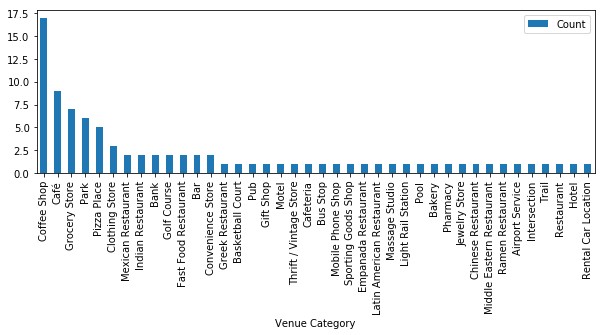

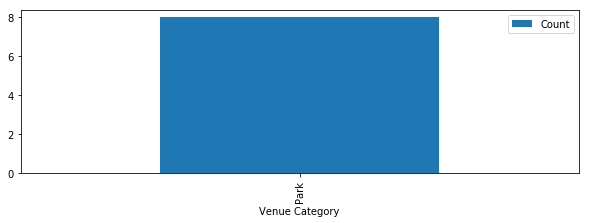

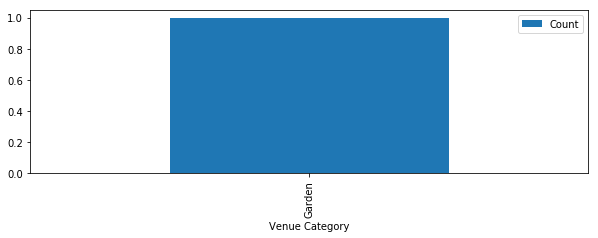

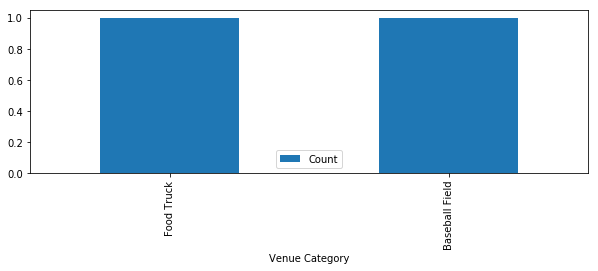

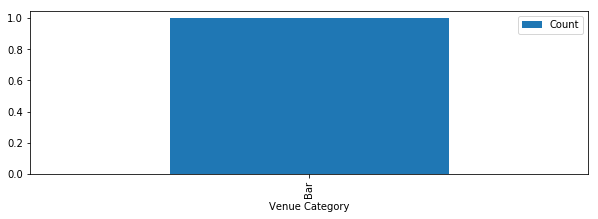

In [108]:
df.groupby('ClusterId').plot(kind = 'bar', x = 'Venue Category', y = 'Count', figsize=(10, 3))

In [39]:
m1[m1['PostalCode'] == 'M6E']

PostalCode Borough          Neighborhood   Latitude  Longitude  \
72        M6E    York  Caledonia-Fairbanks,  43.689026 -79.453512   

    Yoga Studio  Accessories Store  Afghan Restaurant  Airport  \
72          0.0                0.0                0.0      0.0   

    Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
72                 0.0           0.0             0.0              0.0   

    Airport Terminal  American Restaurant  Antique Shop  Aquarium  \
72               0.0                  0.0           0.0       0.0   

    Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
72          0.0                  0.0               0.0                 0.0   

    Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
72            0.0        0.0         0.0         0.0     0.0   0.0  0.0   

    Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
72             0.0               0.0               0.0                 0.0   

    Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
72    0.0              0.0       0.0         0.0                 0.0   

    Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
72        0.0     0.0            0.0        0.0       0.0   

    Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
72                   0.0             0.0      0.0          0.0   

    Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
72              0.0       0.0           0.0            0.0       0.0   

    Bus Station  Bus Stop  Butcher  Cafeteria  Café  \
72          0.0       0.0      0.0        0.0   0.0   

    Cajun / Creole Restaurant  Camera Store  Candy Store  \
72                        0.0           0.0          0.0   

    Caribbean Restaurant  Cheese Shop  Chinese Restaurant  Chocolate Shop  \
72                   0.0          0.0                 0.0             0.0   

    Church  Climbing Gym  Clothing Store  Cocktail Bar  Coffee Shop  \
72     0.0           0.0             0.0           0.0          0.0   

    College Arts Building  College Auditorium  College Cafeteria  College Gym  \
72                    0.0                 0.0                0.0          0.0   

    College Rec Center  College Stadium  Colombian Restaurant  \
72                 0.0              0.0                   0.0   

    Comfort Food Restaurant  Comic Shop  Concert Hall  \
72                      0.0         0.0           0.0   

    Construction & Landscaping  Convenience Store  Cosmetics Shop  \
72                         0.0                0.0             0.0   

    Costume Shop  Coworking Space  Creperie  Cuban Restaurant  Cupcake Shop  \
72           0.0              0.0       0.0               0.0           0.0   

    Curling Ice  Dance Studio  Deli / Bodega  Department Store  Dessert Shop  \
72          0.0           0.0            0.0               0.0           0.0   

    Dim Sum Restaurant  Diner  Discount Store  Distribution Center  Dog Run  \
72                 0.0    0.0             0.0                  0.0      0.0   

    Doner Restaurant  Donut Shop  Drugstore  Dumpling Restaurant  \
72               0.0         0.0        0.0                  0.0   

    Eastern European Restaurant  Electronics Store  Empanada Restaurant  \
72                          0.0                0.0                  0.0   

    Ethiopian Restaurant  Event Space  Falafel Restaurant  Farmers Market  \
72                   0.0          0.0                 0.0             0.0   

    Fast Food Restaurant  Field  Filipino Restaurant  Fish & Chips Shop  \
72                   0.0    0.0                  0.0                0.0   

    Fish Market  Flea Market  Flower Shop  Food  Food & Drink Shop  \
72          0.0          0.0          0.0   0.0                0.0   

    Food Court  Food Truck  Fountain  French Restaurant  Fried Chicken Joint  \
72         0.0         0.0       0.0                0.0       

In [40]:
m1[m1['Cluster Labels'] == 1]

PostalCode           Borough  \
14        M1V       Scarborough   
28        M3K        North York   
38        M4J         East York   
42        M4N   Central Toronto   
46        M4T   Central Toronto   
48        M4W  Downtown Toronto   
72        M6E              York   
88        M8X         Etobicoke   

                                         Neighborhood   Latitude  Longitude  \
14  Agincourt North,L'Amoreaux East,Milliken,Steel...  43.815252 -79.284577   
28                        CFB Toronto,Downsview East,  43.737473 -79.464763   
38                                      East Toronto,  43.685347 -79.338106   
42                                     Lawrence Park,  43.728020 -79.388790   
46                        Moore Park,Summerhill East,  43.689574 -79.383160   
48                                          Rosedale,  43.679563 -79.377529   
72                               Caledonia-Fairbanks,  43.689026 -79.453512   
88       The Kingsway,Montgomery Road,Old Mill North,  43.653654 -79.506944   

    Yoga Studio  Accessories Store  Afghan Restaurant   Airport  \
14          0.0                0.0                0.0  0.000000   
28          0.0                0.0                0.0  0.333333   
38          0.0                0.0                0.0  0.000000   
42          0.0                0.0                0.0  0.000000   
46          0.0                0.0                0.0  0.000000   
48          0.0                0.0                0.0  0.000000   
72          0.0                0.0                0.0  0.000000   
88          0.0                0.0                0.0  0.000000   

    Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
14                 0.0           0.0             0.0              0.0   
28                 0.0           0.0             0.0              0.0   
38                 0.0           0.0             0.0              0.0   
42                 0.0           0.0             0.0              0.0   
46                 0.0           0.0             0.0              0.0   
48                 0.0           0.0             0.0              0.0   
72                 0.0           0.0             0.0              0.0   
88                 0.0           0.0             0.0              0.0   

    Airport Terminal  American Restaurant  Antique Shop  Aquarium  \
14               0.0                  0.0           0.0       0.0   
28               0.0                  0.0           0.0       0.0   
38               0.0                  0.0           0.0       0.0   
42               0.0                  0.0           0.0       0.0   
46               0.0                  0.0           0.0       0.0   
48               0.0                  0.0           0.0       0.0   
72               0.0                  0.0           0.0       0.0   
88               0.0                  0.0           0.0       0.0   

    Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
14          0.0                  0.0               0.0                 0.0   
28          0.0                  0.0               0.0                 0.0   
38          0.0                  0.0               0.0                 0.0   
42          0.0                  0.0               0.0                 0.0   
46          0.0                  0.0               0.0                 0.0   
48          0.0                  0.0               0.0                 0.0   
72          0.0                  0.0               0.0                 0.0   
88          0.0                  0.0               0.0                 0.0   

    Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
14            0.0        0.0         0.0         0.0     0.0   0.0  0.0   
28            0.0        0.0         0.0         0.0     0.0   0.0  0.0   
38            0.0        0.0         0.0         0.0     0.0   0.0  0.0   
42            0.0        0.0         0.0         0.0     0.0   0.0  0.0   
46           

## Working with New York data <a name='newyork_data'></a>

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

In [41]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [42]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [43]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [44]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [45]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

## New York Neighborhoods <a name='newyork_neighborhoods'></a>

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [46]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [47]:
neighborhoods

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

Then let's loop through the data and fill the dataframe one row at a time.

In [48]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [49]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [50]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [51]:
address = 'New York City, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [52]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [53]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

Borough        Neighborhood   Latitude  Longitude
0  Manhattan         Marble Hill  40.876551 -73.910660
1  Manhattan           Chinatown  40.715618 -73.994279
2  Manhattan  Washington Heights  40.851903 -73.936900
3  Manhattan              Inwood  40.867684 -73.921210
4  Manhattan    Hamilton Heights  40.823604 -73.949688

Let's get the geographical coordinates of Manhattan.

In [54]:
address = 'Manhattan, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.

In [55]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [56]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.

In [57]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


## New York Venues <a name='newyork_venues'></a>

#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [58]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=HK3ZHLLVPB3RNF33MU3N120GPO5LEU3OVHEMJBCFMDGXCK5L&client_secret=VEGOVTKT2AKY1OVUCNYHZMFQA0P2EQ2H2YI0IDT1CEJYGM0F&v=20200316&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

Send the GET request and examine the resutls

In [59]:
results = requests.get(url).json()["response"]
results

{'suggestedFilters': {'header': 'Tap to show:',
  'filters': [{'name': 'Open now', 'key': 'openNow'}]},
 'headerLocation': 'Marble Hill',
 'headerFullLocation': 'Marble Hill, New York',
 'headerLocationGranularity': 'neighborhood',
 'totalResults': 25,
 'suggestedBounds': {'ne': {'lat': 40.88105078329964,
   'lng': -73.90471933917806},
  'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
 'groups': [{'type': 'Recommended Places',
   'name': 'recommended',
   'items': [{'reasons': {'count': 0,
      'items': [{'summary': 'This spot is popular',
        'type': 'general',
        'reasonName': 'globalInteractionReason'}]},
     'venue': {'id': '4b4429abf964a52037f225e3',
      'name': "Arturo's",
      'location': {'address': '5198 Broadway',
       'crossStreet': 'at 225th St.',
       'lat': 40.87441177110231,
       'lng': -73.91027100981574,
       'labeledLatLngs': [{'label': 'display',
         'lat': 40.87441177110231,
         'lng': -73.91027100981574}],
       'dista

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [60]:
venues = results['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name   categories        lat        lng
0       Arturo's  Pizza Place  40.874412 -73.910271
1    Bikram Yoga  Yoga Studio  40.876844 -73.906204
2  Tibbett Diner        Diner  40.880404 -73.908937
3        Dunkin'   Donut Shop  40.877136 -73.906666
4      Starbucks  Coffee Shop  40.877531 -73.905582

And how many venues were returned by Foursquare?

In [61]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

25 venues were returned by Foursquare.


<a id='item2'></a>

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [62]:
# type your answer here

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Let's check the size of the resulting dataframe

In [63]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3310, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude          Venue  \
0  Marble Hill              40.876551               -73.91066       Arturo's   
1  Marble Hill              40.876551               -73.91066    Bikram Yoga   
2  Marble Hill              40.876551               -73.91066  Tibbett Diner   
3  Marble Hill              40.876551               -73.91066        Dunkin'   
4  Marble Hill              40.876551               -73.91066      Starbucks   

   Venue Latitude  Venue Longitude Venue Category  
0       40.874412       -73.910271    Pizza Place  
1       40.876844       -73.906204    Yoga Studio  
2       40.880404       -73.908937          Diner  
3       40.877136       -73.906666     Donut Shop  
4       40.877531       -73.905582    Coffee Shop

Let's check how many venues were returned for each neighborhood

In [64]:
manhattan_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                
Battery Park City                       95                      95     95   
Carnegie Hill                          100                     100    100   
Central Harlem                          46                      46     46   
Chelsea                                100                     100    100   
Chinatown                              100                     100    100   
Civic Center                           100                     100    100   
Clinton                                100                     100    100   
East Harlem                             40                      40     40   
East Village                           100                     100    100   
Financial District                     100                     100    100   
Flatiron                               100                     100    100   
Gramercy                               100                     100    100   
Greenwich Village                      100                     100    100   
Hamilton Heights                        60                      60     60   
Hudson Yards                            85                      85     85   
Inwood                                  56                      56     56   
Lenox Hill                             100                     100    100   
Lincoln Square                         100                     100    100   
Little Italy                           100                     100    100   
Lower East Side                         57                      57     57   
Manhattan Valley                        51                      51     51   
Manhattanville                          42                      42     42   
Marble Hill                             25                      25     25   
Midtown                                100                     100    100   
Midtown South                          100                     100    100   
Morningside Heights                     41                      41     41   
Murray Hill                            100                     100    100   
Noho                                   100                     100    100   
Roosevelt Island                        29                      29     29   
Soho                                   100                     100    100   
Stuyvesant Town                         17                      17     17   
Sutton Place                           100                     100    100   
Tribeca                                100                     100    100   
Tudor City                              79                      79     79   
Turtle Bay                             100                     100    100   
Upper East Side                        100                     100    100   
Upper West Side                        100                     100    100   
Washington Heights                      87                      87     87   
West Village                           100                     100    100   
Yorkville                              100                     100    100   

                     Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                          
Battery Park City                95               95              95  
Carnegie Hill                   100              100             100  
Central Harlem                   46               46              46  
Chelsea                         100              100             100  
Chinatown                       100              100             100  
Civic Center                    100              100             100  
Clinton                         100              100             100  
East Harlem                      40               40              40  
East Village                    100              100             100  
Finan

#### Let's find out how many unique categories can be curated from all the returned venues

In [65]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 341 uniques categories.


<a id='item3'></a>

### Analyze Each Neighborhood

In [66]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0  Marble Hill                  0               0                  0   
1  Marble Hill                  0               0                  0   
2  Marble Hill                  0               0                  0   
3  Marble Hill                  0               0                  0   
4  Marble Hill                  0               0                  0   

   African Restaurant  American Restaurant  Antique Shop  Arcade  \
0                   0                    0             0       0   
1                   0                    0             0       0   
2                   0                    0             0       0   
3                   0                    0             0       0   
4                   0                    0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auditorium  \
0                    0                 0                   0           0   
1                    0                 0                   0           0   
2                    0                 0                   0           0   
3                    0                 0                   0           0   
4                    0                 0                   0           0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Baby Store  \
0                      0                    0          0           0   
1                      0                    0          0           0   
2                      0                    0          0           0   
3                      0                    0          0           0   
4                      0                    0          0           0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Basketball Court  \
0           0       0     0    0               0                 0   
1           0       0     0    0               0                 0   
2           0       0     0    0               0                 0   
3           0       0     0    0               0                 0   
4           0       0     0    0               0                 0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0                0         0            0           0              0   
1                0         0            0           0              0   
2                0         0            0           0              0   
3                0         0            0           0              0   
4                0         0            0           0              0   

   Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  Board Shop  \
0                         0          0           0       0           0   
1                         0          0           0       0           0   
2                         0          0           0       0           0   
3                         0          0           0       0           0   
4                         0          0           0       0           0   

   Boat or Ferry  Bookstore  Boutique  Boxing Gym  Brazilian Restaurant  \
0              0          0         0           0                     0   
1              0          0         0           0                     0   
2              0          0         0           0                     0   
3              0          0         0           0                     0   
4              0          0         0           0                     0   

   Breakfast Spot  Bridal Shop  Bridge  Bubble Tea Shop  Building  \
0               0 

And let's examine the new dataframe size.

In [67]:
manhattan_onehot.shape

(3310, 342)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [68]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0     Battery Park City           0.000000            0.00               0.00   
1         Carnegie Hill           0.000000            0.00               0.00   
2        Central Harlem           0.000000            0.00               0.00   
3               Chelsea           0.000000            0.00               0.00   
4             Chinatown           0.000000            0.00               0.00   
5          Civic Center           0.000000            0.00               0.00   
6               Clinton           0.000000            0.00               0.00   
7           East Harlem           0.000000            0.00               0.00   
8          East Village           0.000000            0.00               0.00   
9    Financial District           0.010000            0.00               0.00   
10             Flatiron           0.000000            0.00               0.00   
11             Gramercy           0.000000            0.00               0.00   
12    Greenwich Village           0.000000            0.00               0.00   
13     Hamilton Heights           0.000000            0.00               0.00   
14         Hudson Yards           0.000000            0.00               0.00   
15               Inwood           0.000000            0.00               0.00   
16           Lenox Hill           0.000000            0.00               0.01   
17       Lincoln Square           0.000000            0.00               0.00   
18         Little Italy           0.010000            0.00               0.00   
19      Lower East Side           0.000000            0.00               0.00   
20     Manhattan Valley           0.000000            0.00               0.00   
21       Manhattanville           0.000000            0.00               0.00   
22          Marble Hill           0.000000            0.00               0.00   
23              Midtown           0.000000            0.00               0.00   
24        Midtown South           0.000000            0.00               0.00   
25  Morningside Heights           0.000000            0.00               0.00   
26          Murray Hill           0.000000            0.00               0.00   
27                 Noho           0.000000            0.01               0.00   
28     Roosevelt Island           0.000000            0.00               0.00   
29                 Soho           0.020000            0.00               0.00   
30      Stuyvesant Town           0.000000            0.00               0.00   
31         Sutton Place           0.000000            0.01               0.00   
32              Tribeca           0.000000            0.00               0.00   
33           Tudor City           0.000000            0.00               0.00   
34           Turtle Bay           0.000000            0.00               0.00   
35      Upper East Side           0.000000            0.00               0.00   
36      Upper West Side           0.010000            0.00               0.00   
37   Washington Heights           0.011494            0.00               0.00   
38         West Village           0.010000            0.00               0.00   
39            Yorkville           0.000000            0.00               0.00   

    African Restaurant  American Restaurant  Antique Shop  Arcade  \
0             0.000000             0.010526          0.00    0.00   
1             0.000000             0.010000          0.00    0.00   
2             0.065217             0.043478          0.00    0.00   
3             0.000000             0.030000          0.00    0.00   
4             0.000000             0.040000          0.00    0.00   
5             0.000000             0.030000          0.01    0.00   
6             0.000000             0.040000          0.00    0.00   
7             0.000000             0.000000          0.00    0.00   
8             0.000000             0.020000          0.00    0.00   

#### Let's confirm the new size

In [69]:
manhattan_grouped.shape

(40, 342)

#### Let's print each neighborhood along with the top 5 most common venues

In [70]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.07
1    Coffee Shop  0.06
2          Hotel  0.05
3  Women's Store  0.03
4  Shopping Mall  0.03


----Carnegie Hill----
               venue  freq
0        Pizza Place  0.06
1        Coffee Shop  0.06
2               Café  0.05
3        Yoga Studio  0.03
4  French Restaurant  0.03


----Central Harlem----
                venue  freq
0  African Restaurant  0.07
1  Chinese Restaurant  0.04
2       Deli / Bodega  0.04
3  Seafood Restaurant  0.04
4      Cosmetics Shop  0.04


----Chelsea----
                 venue  freq
0          Coffee Shop  0.06
1   Italian Restaurant  0.05
2               Bakery  0.05
3              Theater  0.03
4  American Restaurant  0.03


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.09
1           Cocktail Bar  0.05
2    American Restaurant  0.04
3  Vietnamese Restaurant  0.04
4      Hotpot Restaurant  0.03


----Civic Center----
                  venue  freq
0     

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [71]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## New York top 10 venues for all neighborhoods <a name='newyork_top10'></a>

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [72]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue    2nd Most Common Venue  \
0     Battery Park City                  Park              Coffee Shop   
1         Carnegie Hill           Pizza Place              Coffee Shop   
2        Central Harlem    African Restaurant      Fried Chicken Joint   
3               Chelsea           Coffee Shop       Italian Restaurant   
4             Chinatown    Chinese Restaurant             Cocktail Bar   
5          Civic Center           Coffee Shop     Gym / Fitness Center   
6               Clinton               Theater       Italian Restaurant   
7           East Harlem    Mexican Restaurant                   Bakery   
8          East Village                   Bar                 Wine Bar   
9    Financial District           Coffee Shop      American Restaurant   
10             Flatiron           Yoga Studio      American Restaurant   
11             Gramercy                   Bar       Italian Restaurant   
12    Greenwich Village    Italian Restaurant           Clothing Store   
13     Hamilton Heights           Pizza Place                     Café   
14         Hudson Yards   American Restaurant       Italian Restaurant   
15               Inwood    Mexican Restaurant                   Lounge   
16           Lenox Hill    Italian Restaurant              Coffee Shop   
17       Lincoln Square                 Plaza                  Theater   
18         Little Italy                  Café                   Bakery   
19      Lower East Side                  Café              Coffee Shop   
20     Manhattan Valley           Pizza Place        Indian Restaurant   
21       Manhattanville           Coffee Shop            Deli / Bodega   
22          Marble Hill                   Gym      American Restaurant   
23              Midtown                 Hotel              Coffee Shop   
24        Midtown South     Korean Restaurant                    Hotel   
25  Morningside Heights                  Park                Bookstore   
26          Murray Hill           Coffee Shop           Sandwich Place   
27                 Noho    Italian Restaurant        French Restaurant   
28     Roosevelt Island                  Park              Coffee Shop   
29                 Soho        Clothing Store                 Boutique   
30      Stuyvesant Town                   Bar            Boat or Ferry   
31         Sutton Place  Gym / Fitness Center                      Gym   
32              Tribeca                  Park       Italian Restaurant   
33           Tudor City                  Park       Mexican Restaurant   
34           Turtle Bay    Italian Restaurant              Coffee Shop   
35      Upper East Side    Italian Restaurant                  Exhibit   
36      Upper West Side    Italian Restaurant                 Wine Bar   
37   Washington Heights                  Café                   Bakery   
38         West Village    Italian Restaurant  New American Restaurant   
39            Yorkville    Italian Restaurant              Coffee Shop   

        3rd Most Common Venue   4th Most Common Venue  5th Most Common Venue  \
0                       Hotel               Wine Shop                    Gym   
1                        Café             Yoga Studio   Gym / Fitness Center   
2          Seafood Restaurant           Deli / Bodega      French Restaurant   
3                      Bakery               Wine Shop    American Restaurant   
4         American Restaurant   Vietnamese Restaurant                    Spa   
5           French Restaurant                   Hotel            Yoga Studio   
6        Gym / Fitness Center     American Restaurant            Coffee Shop   
7   Latin American Restaurant         Thai Restaurant          Deli / Bodega   
8              Ice Cream Shop             Pizza Place           Cocktail Bar   
9                         Bar                     Gym            Pizza Place   
10                       Café    Gym / Fitness Center    Japanese Restaurant   
11         Mexic

<a id='item4'></a>

## New York Neighborhood Clusters <a name='newyork_clusters'></a>

Run *k*-means to cluster the neighborhood into 5 clusters.

In [73]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)
print (kmeans.inertia_)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

0.5692208221347513


array([2, 1, 2, 1, 1, 1, 1, 3, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [74]:
manhattan_merged = manhattan_data

# add clustering labels
manhattan_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

Borough        Neighborhood   Latitude  Longitude  Cluster Labels  \
0  Manhattan         Marble Hill  40.876551 -73.910660               2   
1  Manhattan           Chinatown  40.715618 -73.994279               1   
2  Manhattan  Washington Heights  40.851903 -73.936900               2   
3  Manhattan              Inwood  40.867684 -73.921210               1   
4  Manhattan    Hamilton Heights  40.823604 -73.949688               1   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                   Gym   American Restaurant        Sandwich Place   
1    Chinese Restaurant          Cocktail Bar   American Restaurant   
2                  Café                Bakery         Grocery Store   
3    Mexican Restaurant                Lounge           Pizza Place   
4           Pizza Place                  Café           Coffee Shop   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0            Coffee Shop           Yoga Studio         Deli / Bodega   
1  Vietnamese Restaurant                   Spa    Salon / Barbershop   
2      Mobile Phone Shop       Supplement Shop        Sandwich Place   
3                   Café            Restaurant                  Park   
4          Deli / Bodega    Mexican Restaurant                  Park   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0       Supplement Shop            Steakhouse         Shopping Mall   
1          Optical Shop     Hotpot Restaurant                Bakery   
2    Mexican Restaurant           Coffee Shop          Liquor Store   
3                Bakery    Spanish Restaurant    Chinese Restaurant   
4  Caribbean Restaurant    Chinese Restaurant                School   

  10th Most Common Venue  
0     Seafood Restaurant  
1       Malay Restaurant  
2     Spanish Restaurant  
3     Frozen Yogurt Shop  
4         Sandwich Place

Finally, let's visualize the resulting clusters

In [76]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters: plot number of venues by their category per cluster

In [79]:
g = manhattan_merged.groupby('Cluster Labels')

In [80]:
g.groups

{0: Int64Index([24], dtype='int64'),
 1: Int64Index([1, 3, 4, 5, 6, 10, 12, 16, 17, 18, 19, 23, 27, 29, 32, 34, 35, 36,
             38],
            dtype='int64'),
 2: Int64Index([0, 2, 8, 9, 11, 14, 20, 21, 22, 25, 26, 28, 31, 39], dtype='int64'),
 3: Int64Index([7, 13, 15, 33, 37], dtype='int64'),
 4: Int64Index([30], dtype='int64')}

In [81]:
for name, group in g:
    print (name)
    print (group['1st Most Common Venue'])
    print ('\n')

0
24    Italian Restaurant
Name: 1st Most Common Venue, dtype: object


1
1       Chinese Restaurant
3       Mexican Restaurant
4              Pizza Place
5              Coffee Shop
6       African Restaurant
10      Italian Restaurant
12      Italian Restaurant
16             Coffee Shop
17             Coffee Shop
18      Italian Restaurant
19                     Bar
23          Clothing Store
27                     Bar
29             Coffee Shop
32             Coffee Shop
34    Gym / Fitness Center
35      Italian Restaurant
36                    Park
38             Yoga Studio
Name: 1st Most Common Venue, dtype: object


2
0                     Gym
2                    Café
8      Italian Restaurant
9      Italian Restaurant
11                   Park
14                Theater
20                   Café
21                   Park
22                   Café
25            Pizza Place
26                   Park
28                   Park
31     Italian Restaurant
39    American Restaurant
Na

In [82]:
# create empty dictionary of {'Cluster id' : {'Venue Category' : count}}
d = {}

In [83]:
for name, group in g:
    print (name)
    #for col in ["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue", 
    #            "6th Most Common Venue", "7th Most Common Venue", "8th Most Common Venue", "9th Most Common Venue", "10th Most Common Venue"]:
    s = group["1st Most Common Venue"].value_counts()
    for items in s.iteritems():
        cd = {}
        if name in d:
            cd = d[name]
        else:
            d[name] = {}

        if items[0] in cd:
            cd[items[0]] = int(cd[items[0]]) + int(items[1])
        else:
            if not cd:
                d[name][items[0]] = items[1]
            else:
                cd[items[0]]= items[1]
        print(items[0], items[1])
# 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \

0
Italian Restaurant 1
1
Coffee Shop 5
Italian Restaurant 4
Bar 2
Gym / Fitness Center 1
African Restaurant 1
Mexican Restaurant 1
Chinese Restaurant 1
Clothing Store 1
Yoga Studio 1
Pizza Place 1
Park 1
2
Park 4
Italian Restaurant 3
Café 3
Pizza Place 1
Theater 1
American Restaurant 1
Gym 1
3
Mexican Restaurant 1
Korean Restaurant 1
Plaza 1
Hotel 1
Bar 1
4
Pizza Place 1


In [84]:
d

{0: {'Italian Restaurant': 1},
 1: {'Coffee Shop': 5,
  'Italian Restaurant': 4,
  'Bar': 2,
  'Gym / Fitness Center': 1,
  'African Restaurant': 1,
  'Mexican Restaurant': 1,
  'Chinese Restaurant': 1,
  'Clothing Store': 1,
  'Yoga Studio': 1,
  'Pizza Place': 1,
  'Park': 1},
 2: {'Park': 4,
  'Italian Restaurant': 3,
  'Café': 3,
  'Pizza Place': 1,
  'Theater': 1,
  'American Restaurant': 1,
  'Gym': 1},
 3: {'Mexican Restaurant': 1,
  'Korean Restaurant': 1,
  'Plaza': 1,
  'Hotel': 1,
  'Bar': 1},
 4: {'Pizza Place': 1}}

In [85]:
type(d)

dict

In [86]:
df = pd.DataFrame(columns=['ClusterId', 'Venue Category', 'Count'])

for cluster in d:
    c = d[cluster]
    for vc in c:
        df = df.append({'ClusterId' : cluster, 'Venue Category' : vc, 'Count' : c[vc]}, ignore_index = True)

df.head()

ClusterId        Venue Category Count
0         0    Italian Restaurant     1
1         1           Coffee Shop     5
2         1    Italian Restaurant     4
3         1                   Bar     2
4         1  Gym / Fitness Center     1

ClusterId
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

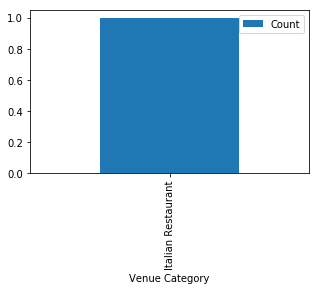

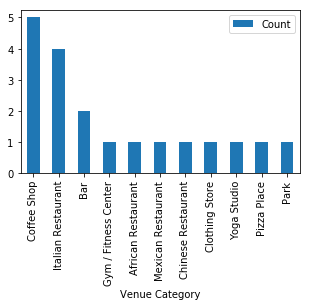

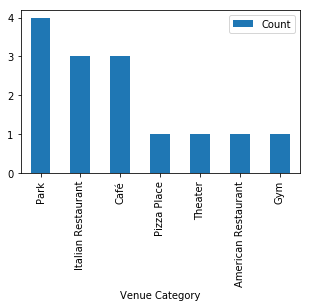

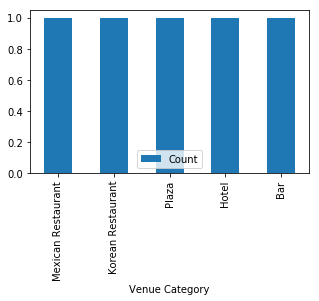

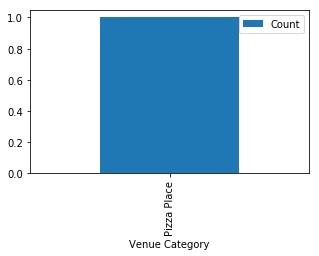

In [93]:
df.groupby('ClusterId').plot(kind = 'bar', x = 'Venue Category', y = 'Count', figsize=(5, 3))

## Explore Recommended Cluster <a name='recommended_cluster'></a>

In [ ]:
mf = manhattan_merged[manhattan_merged['Cluster Labels'] == 2]

In [112]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mf['Latitude'], mf['Longitude'], mf['Neighborhood'], mf['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [109]:
manhattan_merged[manhattan_merged['Cluster Labels'] == 2]

Borough         Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Manhattan          Marble Hill  40.876551 -73.910660               2   
2   Manhattan   Washington Heights  40.851903 -73.936900               2   
8   Manhattan      Upper East Side  40.775639 -73.960508               2   
9   Manhattan            Yorkville  40.775930 -73.947118               2   
11  Manhattan     Roosevelt Island  40.762160 -73.949168               2   
14  Manhattan              Clinton  40.759101 -73.996119               2   
20  Manhattan      Lower East Side  40.717807 -73.980890               2   
21  Manhattan              Tribeca  40.721522 -74.010683               2   
22  Manhattan         Little Italy  40.719324 -73.997305               2   
25  Manhattan     Manhattan Valley  40.797307 -73.964286               2   
26  Manhattan  Morningside Heights  40.808000 -73.963896               2   
28  Manhattan    Battery Park City  40.711932 -74.016869               2   
31  Manhattan                 Noho  40.723259 -73.988434               2   
39  Manhattan         Hudson Yards  40.756658 -74.000111               2   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                    Gym   American Restaurant        Sandwich Place   
2                   Café                Bakery         Grocery Store   
8     Italian Restaurant               Exhibit           Art Gallery   
9     Italian Restaurant           Coffee Shop                   Gym   
11                  Park           Coffee Shop         Deli / Bodega   
14               Theater    Italian Restaurant  Gym / Fitness Center   
20                  Café           Coffee Shop           Pizza Place   
21                  Park    Italian Restaurant   American Restaurant   
22                  Café                Bakery       Bubble Tea Shop   
25           Pizza Place     Indian Restaurant                   Bar   
26                  Park             Bookstore   American Restaurant   
28                  Park           Coffee Shop                 Hotel   
31    Italian Restaurant     French Restaurant                 Hotel   
39   American Restaurant    Italian Restaurant           Coffee Shop   

   4th Most Common Venue 5th Most Common Venue     6th Most Common Venue  \
0            Coffee Shop           Yoga Studio             Deli / Bodega   
2      Mobile Phone Shop       Supplement Shop            Sandwich Place   
8                 Bakery           Coffee Shop      Gym / Fitness Center   
9                    Bar         Deli / Bodega               Pizza Place   
11        Sandwich Place        Scenic Lookout                       Gym   
14   American Restaurant           Coffee Shop                       Spa   
20           Art Gallery          Cocktail Bar       Japanese Restaurant   
21                  Café                   Spa                  Boutique   
22        Sandwich Place    Salon / Barbershop  Mediterranean Restaurant   
25           Yoga Studio       Thai Restaurant                Playground   
26           Coffee Shop          Burger Joint            Sandwich Place   
28             Wine Shop                   Gym             Shopping Mall   
31          Cocktail Bar             Rock Club               Art Gallery   
39                 Hotel  Gym / Fitness Center                      Café   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0        Supplement Shop            Steakhouse         Shopping Mall   
2     Mexican Restaurant           Coffee Shop          Liquor Store   
8              Juice Bar                 Hotel     French Restaurant   
9       Sushi Restaurant   Japanese Restaurant    Mexican Restaurant   
11           Dry Cleaner        Baseball Field          Liquor Store   
14        Sandwich Place                 Hotel             Wine Shop   
20                Bakery      Ramen Restaurant    Chinese Restaurant   
21              Wine Bar             Wine Shop           Coffee Sho

## Compare top 10 venues of recommended neighborhood with that  of originating neighborhood <a name='compare'></a>

In [113]:
manhattan_merged[manhattan_merged['Neighborhood'] == 'Battery Park City']

Borough       Neighborhood   Latitude  Longitude  Cluster Labels  \
28  Manhattan  Battery Park City  40.711932 -74.016869               2   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
28                  Park           Coffee Shop                 Hotel   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
28             Wine Shop                   Gym         Shopping Mall   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
28         Women's Store         Memorial Site            Food Court   

   10th Most Common Venue  
28            Men's Store

In [114]:
m1[m1['PostalCode'] == 'M6E']

PostalCode Borough          Neighborhood   Latitude  Longitude  \
72        M6E    York  Caledonia-Fairbanks,  43.689026 -79.453512   

    Yoga Studio  Accessories Store  Afghan Restaurant  Airport  \
72          0.0                0.0                0.0      0.0   

    Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
72                 0.0           0.0             0.0              0.0   

    Airport Terminal  American Restaurant  Antique Shop  Aquarium  \
72               0.0                  0.0           0.0       0.0   

    Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
72          0.0                  0.0               0.0                 0.0   

    Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
72            0.0        0.0         0.0         0.0     0.0   0.0  0.0   

    Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
72             0.0               0.0               0.0                 0.0   

    Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
72    0.0              0.0       0.0         0.0                 0.0   

    Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
72        0.0     0.0            0.0        0.0       0.0   

    Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
72                   0.0             0.0      0.0          0.0   

    Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
72              0.0       0.0           0.0            0.0       0.0   

    Bus Station  Bus Stop  Butcher  Cafeteria  Café  \
72          0.0       0.0      0.0        0.0   0.0   

    Cajun / Creole Restaurant  Camera Store  Candy Store  \
72                        0.0           0.0          0.0   

    Caribbean Restaurant  Cheese Shop  Chinese Restaurant  Chocolate Shop  \
72                   0.0          0.0                 0.0             0.0   

    Church  Climbing Gym  Clothing Store  Cocktail Bar  Coffee Shop  \
72     0.0           0.0             0.0           0.0          0.0   

    College Arts Building  College Auditorium  College Cafeteria  College Gym  \
72                    0.0                 0.0                0.0          0.0   

    College Rec Center  College Stadium  Colombian Restaurant  \
72                 0.0              0.0                   0.0   

    Comfort Food Restaurant  Comic Shop  Concert Hall  \
72                      0.0         0.0           0.0   

    Construction & Landscaping  Convenience Store  Cosmetics Shop  \
72                         0.0                0.0             0.0   

    Costume Shop  Coworking Space  Creperie  Cuban Restaurant  Cupcake Shop  \
72           0.0              0.0       0.0               0.0           0.0   

    Curling Ice  Dance Studio  Deli / Bodega  Department Store  Dessert Shop  \
72          0.0           0.0            0.0               0.0           0.0   

    Dim Sum Restaurant  Diner  Discount Store  Distribution Center  Dog Run  \
72                 0.0    0.0             0.0                  0.0      0.0   

    Doner Restaurant  Donut Shop  Drugstore  Dumpling Restaurant  \
72               0.0         0.0        0.0                  0.0   

    Eastern European Restaurant  Electronics Store  Empanada Restaurant  \
72                          0.0                0.0                  0.0   

    Ethiopian Restaurant  Event Space  Falafel Restaurant  Farmers Market  \
72                   0.0          0.0                 0.0             0.0   

    Fast Food Restaurant  Field  Filipino Restaurant  Fish & Chips Shop  \
72                   0.0    0.0                  0.0                0.0   

    Fish Market  Flea Market  Flower Shop  Food  Food & Drink Shop  \
72          0.0          0.0          0.0   0.0                0.0   

    Food Court  Food Truck  Fountain  French Restaurant  Fried Chicken Joint  \
72         0.0         0.0       0.0                0.0       